In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
movies = pd.read_csv('movies.csv')

In [2]:
# the function to extract titles 
def extract_title(title):
   year = title[len(title)-5:len(title)-1]
   
   # some movies do not have the info about year in the column title. So, we should take care of the case as well.
   
   if year.isnumeric():
      title_no_year = title[:len(title)-7]
      return title_no_year
   else:
      return title
# the function to extract years
def extract_year(title):
   year = title[len(title)-5:len(title)-1]
   # some movies do not have the info about year in the column title. So, we should take care of the case as well.
   if year.isnumeric():
      return int(year)
   else:
      return np.nan
# change the column name from title to title_year
movies.rename(columns={'title':'title_year'}, inplace=True) 
# remove leading and ending whitespaces in title_year
movies['title_year'] = movies['title_year'].apply(lambda x: x.strip()) 
# create the columns for title and year
movies['title'] = movies['title_year'].apply(extract_title) 
movies['year'] = movies['title_year'].apply(extract_year)

In [3]:
r,c = movies[movies['genres']=='(no genres listed)'].shape
print('The number of movies which do not have info about genres:',r)
# [Out] The number of movies which do not have info about genres: 34
# remove the movies without genre information and reset the index
movies = movies[~(movies['genres']=='(no genres listed)')].reset_index(drop=True)

The number of movies which do not have info about genres: 7


Text(0, 0.5, 'Counts')

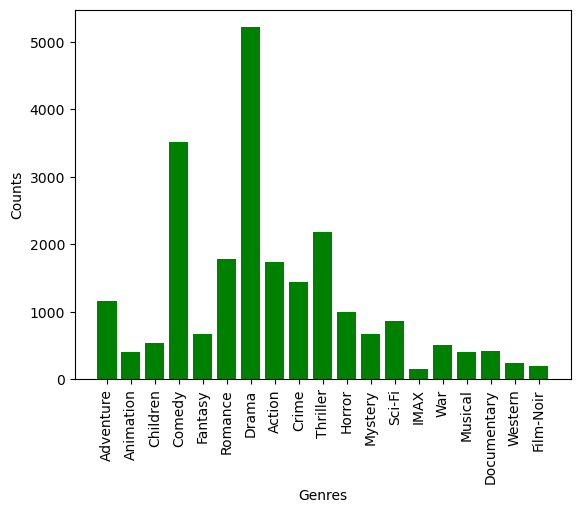

In [4]:
# remove '|' in the genres column
movies['genres'] = movies['genres'].str.replace('|',' ')
# count the number of occurences for each genre in the data set
counts = dict()
for i in movies.index:
   for g in movies.loc[i,'genres'].split(' '):
      if g not in counts:
         counts[g] = 1
      else:
         counts[g] = counts[g] + 1
# create a bar chart
plt.bar(list(counts.keys()), counts.values(), color='g')
plt.xticks(rotation=90)
plt.xlabel('Genres')
plt.ylabel('Counts')

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
# change 'Sci-Fi' to 'SciFi' and 'Film-Noir' to 'Noir'
movies['genres'] = movies['genres'].str.replace('Sci-Fi','SciFi')
movies['genres'] = movies['genres'].str.replace('Film-Noir','Noir')
# create an object for TfidfVectorizer
tfidf_vector = TfidfVectorizer(stop_words='english')
# apply the object to the genres column
tfidf_matrix = tfidf_vector.fit_transform(movies['genres'])

In [6]:
tfidf_matrix.shape
# [Out] (9708, 19)

(10322, 19)

In [7]:
# print(list(enumerate(tfidf_vector.get_feature_names())))

In [8]:
from sklearn.metrics.pairwise import linear_kernel
# create the cosine similarity matrix
sim_matrix = linear_kernel(tfidf_matrix,tfidf_matrix)
print(sim_matrix)

[[1.         0.79977424 0.15889209 ... 0.26380029 0.26380029 0.        ]
 [0.79977424 1.         0.         ... 0.         0.         0.        ]
 [0.15889209 0.         1.         ... 0.60231965 0.60231965 0.        ]
 ...
 [0.26380029 0.         0.60231965 ... 1.         1.         0.        ]
 [0.26380029 0.         0.60231965 ... 1.         1.         0.        ]
 [0.         0.         0.         ... 0.         0.         1.        ]]


In [9]:
pip install fuzzywuzzy

Note: you may need to restart the kernel to use updated packages.


In [10]:
from fuzzywuzzy import fuzz
# create a function to find the closest title
def matching_score(a,b):
   return fuzz.ratio(a,b)

C:\Users\lenovo\anaconda3\Lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [11]:
# a function to convert index to title_year
def get_title_year_from_index(index):
   return movies[movies.index == index]['title_year'].values[0]
# a function to convert index to title
def get_title_from_index(index):
   return movies[movies.index == index]['title'].values[0]
# a function to convert title to index
def get_index_from_title(title):
   return movies[movies.title == title].index.values[0]
# a function to return the most similar title to the words a user type
def find_closest_title(title):
   leven_scores = list(enumerate(movies['title'].apply(matching_score, b=title)))
   sorted_leven_scores = sorted(leven_scores, key=lambda x: x[1], reverse=True)
   closest_title = get_title_from_index(sorted_leven_scores[0][0])
   distance_score = sorted_leven_scores[0][1]
   return closest_title, distance_score

In [12]:
def contents_based_recommender(movie_user_likes, how_many):
   closest_title, distance_score = find_closest_title(movie_user_likes)
   # When a user does not make misspellings
   if distance_score == 100:
      movie_index = get_index_from_title(closest_title)
      movie_list = list(enumerate(sim_matrix[int(movie_index)]))
      # remove the typed movie itself
      similar_movies = list(filter(lambda x:x[0] != int(movie_index), sorted(movie_list,key=lambda x:x[1], reverse=True))) 
      
      print('Here\'s the list of movies similar to '+'\033[1m'+str(closest_title)+'\033[0m'+'.\n')
      for i,s in similar_movies[:how_many]:
         print(get_title_year_from_index(i))
   # When a user makes misspellings    
   else:
      print('Did you mean '+'\033[1m'+str(closest_title)+'\033[0m'+'?','\n')
      movie_index = get_index_from_title(closest_title)
      movie_list = list(enumerate(sim_matrix[int(movie_index)]))
      similar_movies = list(filter(lambda x:x[0] != int(movie_index), sorted(movie_list,key=lambda x:x[1], reverse=True)))
      print('Here\'s the list of movies similar to '+'\033[1m'+str(closest_title)+'\033[0m'+'.\n')
      for i,s in similar_movies[:how_many]:
         print(get_title_year_from_index(i))

In [13]:
print("Movie Recommendations : ")
contents_based_recommender("Romance" , 5)

Movie Recommendations : 
Here's the list of movies similar to Romance.

Sense and Sensibility (1995)
Leaving Las Vegas (1995)
Persuasion (1995)
Carrington (1995)
How to Make an American Quilt (1995)


In [14]:
movies

,movieId,title_year,genres,title,year
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,Toy Story,1995.0
1,2,Jumanji (1995),Adventure Children Fantasy,Jumanji,1995.0
2,3,Grumpier Old Men (1995),Comedy Romance,Grumpier Old Men,1995.0
3,4,Waiting to Exhale (1995),Comedy Drama Romance,Waiting to Exhale,1995.0
4,5,Father of the Bride Part II (1995),Comedy,Father of the Bride Part II,1995.0
...,...,...,...,...,...
10317,146656,Creed (2015),Drama,Creed,2015.0
10318,146684,Cosmic Scrat-tastrophe (2015),Animation Children Comedy,Cosmic Scrat-tastrophe,2015.0
10319,146878,Le Grand Restaurant (1966),Comedy,Le Grand Restaurant,1966.0
10320,148238,A Very Murray Christmas (2015),Comedy,A Very Murray Christmas,2015.0


In [18]:
while True :
    try: 
        Movie_genre=input("Movie_genre :  ")
        No_of_Recom =int(input("No_Of_Recommendatoin (Enter Number : )  : "))
        contents_based_recommender(Movie_genre , No_of_Recom)
    except ValueError:
        print("Plz Enter Number ! ")   
        continue 
    else :
        break

Movie_genre :  Advenuture
No_Of_Recommendatoin (Enter Number : )  : 4
Did you mean Adventureland? 

Here's the list of movies similar to Adventureland.

Kicking and Screaming (1995)
Big Bully (1996)
Antonia's Line (Antonia) (1995)
Last Summer in the Hamptons (1995)
